<a href="https://colab.research.google.com/github/eshikapathak/Personalized-Federated-Learning/blob/main/Basic/FedAvg_and_FedSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FedAvg

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [119]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [120]:
def iid_loader(dataset, num_clients=100, batch_size=10):
    total = len(dataset)
    indices = torch.randperm(total).tolist()
    data_per_client = total // num_clients
    client_indices = [indices[i * data_per_client:(i + 1) * data_per_client] for i in range(num_clients)]

    client_loaders = [
        DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=True)
        for indices in client_indices
    ]
    return client_loaders

In [137]:
def non_iid_loader(dataset, num_clients=100, batch_size=10, classes_per_user=2, high_prob=0.6, low_prob=0.4):
    # Helper function to get number of classes and labels
    def get_num_classes_samples(data):
        if isinstance(data.targets, list):
            labels = np.array(data.targets)
        else:
            labels = data.targets.numpy()
        classes, num_samples = np.unique(labels, return_counts=True)
        return len(classes), num_samples, labels

    # Helper function to generate data split based on class partitions
    def gen_data_split(num_samples, labels, class_partitions):
        data_class_idx = {i: np.where(labels == i)[0] for i in range(num_classes)}
        for idx_list in data_class_idx.values():
            random.shuffle(idx_list)

        user_data_idx = [[] for _ in range(num_clients)]
        for usr_i in range(num_clients):
            for c, p in zip(class_partitions['class'][usr_i], class_partitions['prob'][usr_i]):
                end_idx = int(p * num_samples[c])
                user_data_idx[usr_i].extend(data_class_idx[c][:end_idx])
                data_class_idx[c] = data_class_idx[c][end_idx:]
        return user_data_idx

    num_classes, num_samples, labels = get_num_classes_samples(dataset)
    count_per_class = (classes_per_user * num_clients) // num_classes

    # Generating class partitions
    class_dict = {i: {'prob': np.random.uniform(low_prob, high_prob, size=count_per_class).tolist()} for i in range(num_classes)}
    for probs in class_dict.values():
        total = sum(probs['prob'])
        probs['prob'] = [p / total for p in probs['prob']]

    # Assign classes and probabilities to each client
    class_partitions = {'class': [], 'prob': []}
    available_classes = list(range(num_classes)) * count_per_class
    random.shuffle(available_classes)
    for _ in range(num_clients):
        client_classes = random.sample(available_classes, classes_per_user)
        for c in client_classes:
            available_classes.remove(c)
        client_probs = [class_dict[c]['prob'].pop() for c in client_classes]
        class_partitions['class'].append(client_classes)
        class_partitions['prob'].append(client_probs)

    # Generating data splits
    user_data_idx = gen_data_split(num_samples, labels, class_partitions)

    # Creating data loaders
    client_data_loaders = []
    for indices in user_data_idx:
        subset = Subset(dataset, indices)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        client_data_loaders.append(loader)

    return client_data_loaders

In [134]:
batch_size = 64
num_clients = 100
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

iid_client_train_loader = iid_loader(train_data, num_clients, batch_size)
non_iid_client_train_loader = non_iid_loader(train_data, num_clients, batch_size, classes_per_user=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Models

In [124]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
        )

    def forward(self, x):
        x = x.flatten(1)
        x = self.nn(x)
        return x

class CNN(nn.Module):
    def __init__(self, in_channels=3, n_kernels=16, out_dim=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, n_kernels, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_kernels, 2 * n_kernels, 5)
        self.fc1 = nn.Linear(2 * n_kernels * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [77]:
from torchsummary import summary
mlp = SimpleMLP().to(device)
summary(mlp,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
              ReLU-2                  [-1, 200]               0
            Linear-3                  [-1, 200]          40,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [125]:
cnn = CNN().to(device)
summary(cnn,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 10, 10]          12,832
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                  [-1, 120]          96,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 121,182
Trainable params: 121,182
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.46
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


In [79]:
criterion = nn.CrossEntropyLoss()

In [81]:
def train(model, client_train_loader, epochs, optimizer):
    model.train()
    for _ in range(epochs):
        for _, (data, target) in enumerate(client_train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model

def evaluate(model):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax( dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    acc = correct / total
    return acc

In [82]:
def running_model_average(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key]*scale
    else:
        for key in current:
            current[key] = current[key] + next[key]*scale
    return current

In [92]:
def experiments(global_model, client_frac, epochs, lr, train_loader, max_rounds):
    accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        clients = np.random.choice(np.arange(num_clients), int(num_clients*client_frac), replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None
        for i, c in enumerate(clients):
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients*client_frac, c))
            local_model = copy.deepcopy(global_model).to(device)
            optimizer = torch.optim.SGD(local_model.parameters(), lr = lr)
            local_model = train(local_model, train_loader[c], epochs=epochs, optimizer=optimizer)
            running_avg = running_model_average(running_avg, local_model.state_dict(), 1/(num_clients*client_frac))
        
        global_model.load_state_dict(running_avg)
        val_acc = evaluate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        accuracy.append(val_acc)

    return np.array(accuracy)

In [ ]:
cnn = CNN()
cnn_iid_10 = copy.deepcopy(cnn)
acc_cnn_iid_10_1_1 = experiments(cnn_iid_10, client_frac=0.1, epochs=5, lr=0.05, train_loader=non_iid_client_train_loader, max_rounds=1000)
print(acc_cnn_iid_10_1_1)

In [ ]:
mlp = SimpleMLP()
mlp_iid_10 = copy.deepcopy(mlp)
acc_mlp_iid_10 = experiments(mlp_iid_10, client_frac=0.1, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_10)

In [ ]:
mlp = SimpleMLP()
mlp_iid_20 = copy.deepcopy(mlp)
acc_mlp_iid_20 = experiments(mlp_iid_20, client_frac=0.2, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_20)

In [ ]:
mlp = SimpleMLP()
mlp_iid_50 = copy.deepcopy(mlp)
acc_mlp_iid_50 = experiments(mlp_iid_50, client_frac=0.5, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_50)

In [ ]:
mlp = SimpleMLP()
mlp_iid_100 = copy.deepcopy(mlp)
acc_mlp_iid_100 = experiments(mlp_iid_100, client_frac=1, epochs=1, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_mlp_iid_100)

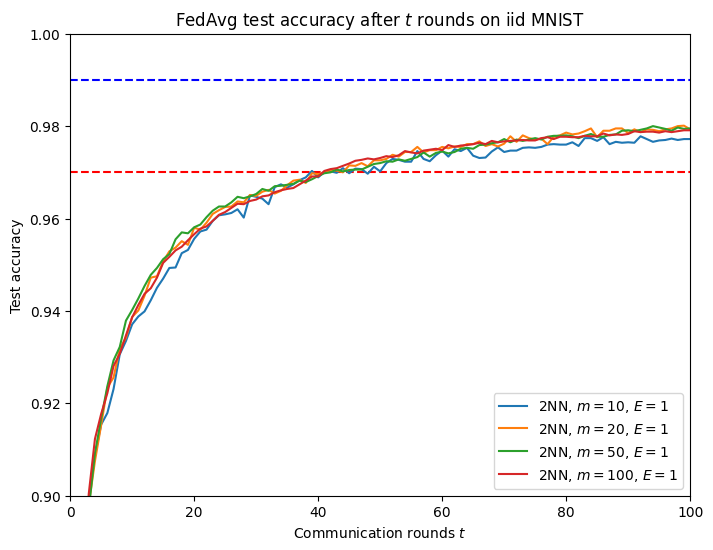

In [97]:
x = np.arange(1,101)
plt.figure(figsize=(8,6))

plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")

plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 100, 0.9, 1])

plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_mlp_iid_10, label='2NN, $m=10$, $E=1$')
plt.plot(x, acc_mlp_iid_20, label='2NN, $m=20$, $E=1$')
plt.plot(x, acc_mlp_iid_50, label='2NN, $m=50$, $E=1$')
plt.plot(x, acc_mlp_iid_100, label='2NN, $m=100$, $E=1$')

plt.legend()
plt.show()

In [ ]:
cnn = CNN()
cnn_iid_10 = copy.deepcopy(cnn)
acc_cnn_iid_10 = experiments(cnn_iid_10, client_frac=0.1, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_10)

In [ ]:
cnn = CNN()
cnn_iid_20 = copy.deepcopy(cnn)
acc_cnn_iid_20 = experiments(cnn_iid_20, client_frac=0.2, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_20)

In [ ]:
cnn = CNN()
cnn_iid_50 = copy.deepcopy(cnn)
acc_cnn_iid_50 = experiments(cnn_iid_50, client_frac=0.5, epochs=5, lr=0.05, train_loader=iid_client_train_loader, max_rounds=100)
print(acc_cnn_iid_50)

In [ ]:
x = np.arange(1,101)
plt.figure(figsize=(8,6))

plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")

plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 100, 0.9, 1])

plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_mlp_iid_10, label='2NN, $m=10$, $E=1$')
plt.plot(x, acc_mlp_iid_20, label='2NN, $m=20$, $E=1$')
plt.plot(x, acc_mlp_iid_50, label='2NN, $m=50$, $E=1$')
plt.plot(x, acc_mlp_iid_100, label='2NN, $m=100$, $E=1$')

plt.plot(x, acc_cnn_iid_10, label='CNN, $m=10$, $E=5$')
plt.plot(x, acc_cnn_iid_20, label='CNN, $m=20$, $E=5$')
plt.plot(x, acc_cnn_iid_50, label='CNN, $m=50$, $E=5$')
plt.plot(x, acc_cnn_iid_100, label='CNN, $m=100$, $E=5$')

plt.legend()
plt.show()